In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv("used_cars.csv")

Pre-prossesing Steps:

In [3]:
# 1: Clean price column (convert steing to int)
df['price'] = df['price'].str.replace("[$,]", "", regex=True).astype(int)

In [4]:
# 2: Clean milage column (remove 'mi.' and commas and convert from string to int)
df['milage'] = df['milage'].str.replace("[, mi.]", "", regex=True).astype(int)

In [5]:
# 3: Create car age (2025-model_year)
df['car_age'] = 2025 - df['model_year']

In [6]:
# 4: Split 'engine' column into 2 new columns: 'horsepower' and 'engine_liter'
df['horsepower'] = df['engine'].str.extract(r"(\d+\.?\d*)HP").astype(float)

df['engine_liters'] = df['engine'].str.extract(r"(\d+\.?\d*)L").astype(float)

df.drop('engine', axis=1, inplace=True)

In [7]:
# 5: Make clean_title boolean
df['clean_title'] = df['clean_title'].apply(lambda x: 1 if str(x).strip().lower() == "yes" else 0)

In [8]:
# 6: Convert 'accident' boolean (1 = accident reported, 0 = none)
df['accident'] = df['accident'].apply(lambda x: 0 if "none" in str(x).lower() else 1)

In [10]:
# 6: Handle missing values
df['fuel_type'] = df['fuel_type'].fillna(df['fuel_type'].mode()[0])
df['accident'] = df['accident'].fillna("None reported")
df['clean_title'] = df['clean_title'].fillna("Yes")

In [9]:
# 7: Drop any rows with missing values
df = df.dropna(axis=0).reset_index(drop=True)

print("Dataset shape after dropping NaNs:", df.shape)

Dataset shape after dropping NaNs: (3062, 14)


In [11]:
df.head()

,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,car_age,horsepower,engine_liters
0,Ford,Utility Police Interceptor Base,2013,51000,E85 Flex Fuel,6-Speed A/T,Black,Black,1,1,10300,12,300.0,3.7
1,INFINITI,Q50 Hybrid Sport,2015,88900,Hybrid,7-Speed A/T,Black,Black,0,1,15500,10,354.0,3.5
2,Audi,S3 2.0T Premium Plus,2017,84000,Gasoline,6-Speed A/T,Blue,Black,0,1,31000,8,292.0,2.0
3,BMW,740 iL,2001,242000,Gasoline,A/T,Green,Green,0,1,7300,24,282.0,4.4
4,Lexus,RC 350 F Sport,2021,23436,Gasoline,6-Speed A/T,Black,Black,0,1,41927,4,311.0,3.5


Train/test Split

In [12]:
# Features and target
X = df.drop('price', axis=1)
y = df['price']

# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (2449, 13)
Test shape: (613, 13)


In [13]:
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical features:", categorical_cols)
print("Numeric features:", numeric_cols)

Categorical features: ['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col']
Numeric features: ['model_year', 'milage', 'accident', 'clean_title', 'car_age', 'horsepower', 'engine_liters']


Preprocessing Pipeline

In [14]:
# Numeric pipeline: scale features
numeric_transformer = StandardScaler()

# Categorical pipeline: one-hot encode
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Build preprocessing transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

print("ready")

ready


Experiment 1: Baeline Linear Regression

In [15]:
# Build pipeline: preprocessing + linear regression
baseline_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [16]:
# Train & Predict on test set
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)

In [18]:
# Baseline Evaluation
rmse_bl = np.sqrt(mean_squared_error(y_test, y_pred))
mae_bl = mean_absolute_error(y_test, y_pred)
r2_bl = r2_score(y_test, y_pred)

print("Baseline Linear Regression Results:")
print(f"RMSE: {rmse_bl:,.2f}")
print(f"MAE: {mae_bl:,.2f}")
print(f"R²: {r2_bl:.3f}")

Baseline Linear Regression Results:
RMSE: 89,579.62
MAE: 18,119.15
R²: -0.387


Experiment 2: Improved Regression

In [19]:
# 1: Log all the prices (more accurate model) and simplify transmission to Auto/Manual)
df['log_price'] = np.log(df['price'])

df['transmission'] = df['transmission'].apply(
    lambda x: "Manual" if "manual" in str(x).lower() else "Automatic"
)

In [20]:
# Features and target
X = df.drop(['price', 'log_price'], axis=1)
y = df['log_price']  

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [22]:
# Identify column types again
categorical_cols = X_train.select_dtypes(include=['object']).columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns

# Preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [23]:
# Model
improved_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [24]:
# Train and Predict
improved_model.fit(X_train, y_train)

y_pred_log = improved_model.predict(X_test)
y_pred = np.exp(y_pred_log)

In [25]:
# Evaluation (compare vs real price, not log)
rmse = np.sqrt(mean_squared_error(np.exp(y_test), y_pred))
mae = mean_absolute_error(np.exp(y_test), y_pred)
r2 = r2_score(np.exp(y_test), y_pred)

print("Experiment 2: Improved Regression")
print(f"RMSE: {rmse:,.2f}")
print(f"MAE: {mae:,.2f}")
print(f"R²: {r2:.3f}")  

Experiment 2: Improved Regression
RMSE: 66,703.97
MAE: 10,610.76
R²: 0.231


Experiment 3: Random Forest Regression

In [26]:
# Build pipeline
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, random_state=42))
])

In [27]:
# Train and Predict
rf_model.fit(X_train, y_train)

y_pred_rf_log = rf_model.predict(X_test)
y_pred_rf = np.exp(y_pred_rf_log)

In [28]:
# Evaluation
rmse_rf = np.sqrt(mean_squared_error(np.exp(y_test), y_pred_rf))
mae_rf = mean_absolute_error(np.exp(y_test), y_pred_rf)
r2_rf = r2_score(np.exp(y_test), y_pred_rf)

print("Experiment 3: Random Forest Regression")
print(f"RMSE: {rmse_rf:,.2f}")
print(f"MAE: {mae_rf:,.2f}")
print(f"R²: {r2_rf:.3f}")

Experiment 3: Random Forest Regression
RMSE: 63,789.13
MAE: 10,329.33
R²: 0.297


Results

In [29]:
# Compress all results in one place
results = pd.DataFrame({
    "Experiment": [
        "Baseline Linear Regression",
        "Improved Linear Regression (log + features)",
        "Random Forest Regression"
    ],
    "RMSE": [rmse_bl, rmse, rmse_rf],  
    "MAE": [mae_bl, mae, mae_rf],       
    "R²": [r2_bl, r2, r2_rf]            
})

# Format nicely
results = results.round(3)
print(results)


                                    Experiment       RMSE        MAE     R²
0                   Baseline Linear Regression  89579.620  18119.154 -0.387
1  Improved Linear Regression (log + features)  66703.973  10610.761  0.231
2                     Random Forest Regression  63789.128  10329.326  0.297


Graphs

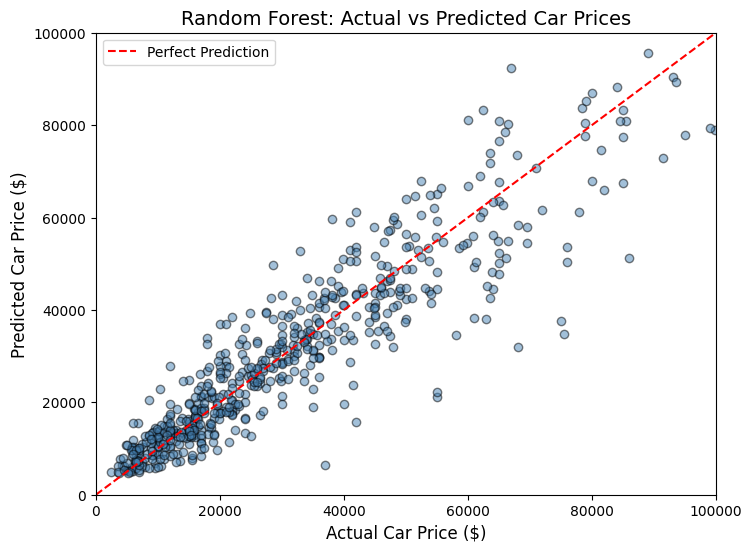

In [30]:
# 1: Actual vs  Predicted Prices

plt.figure(figsize=(8,6))
plt.scatter(np.exp(y_test), y_pred_rf, alpha=0.5, c="steelblue", edgecolor="k")

# Plot perfect prediction line
plt.plot([0, 100000], [0, 100000], color="red", linestyle="--", label="Perfect Prediction")

# Zoom in (most cars are < $100k)
plt.xlim(0, 100000)
plt.ylim(0, 100000)

plt.xlabel("Actual Car Price ($)", fontsize=12)
plt.ylabel("Predicted Car Price ($)", fontsize=12)
plt.title("Random Forest: Actual vs Predicted Car Prices", fontsize=14)
plt.legend()
plt.show()

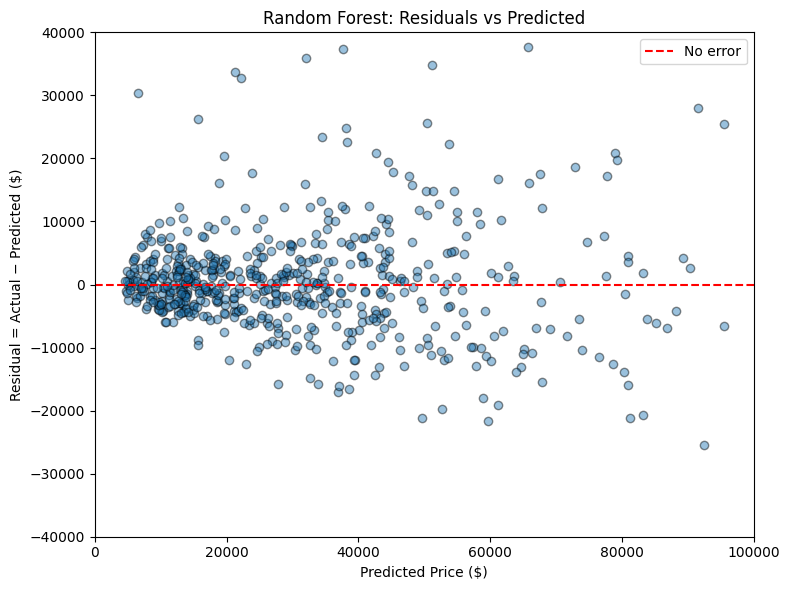

In [31]:
#2: Residula Plot (predicts Errors)

actual = np.exp(y_test)          
pred   = y_pred_rf
resid  = actual - pred

plt.figure(figsize=(8,6))
plt.scatter(pred, resid, alpha=0.45, edgecolor="k")
plt.axhline(0, ls="--", c="red", label="No error")
plt.xlabel("Predicted Price ($)")
plt.ylabel("Residual = Actual − Predicted ($)")
plt.title("Random Forest: Residuals vs Predicted")
plt.legend()
plt.xlim(0, 100000)               
plt.ylim(-40000, 40000)           
plt.tight_layout()
plt.show()

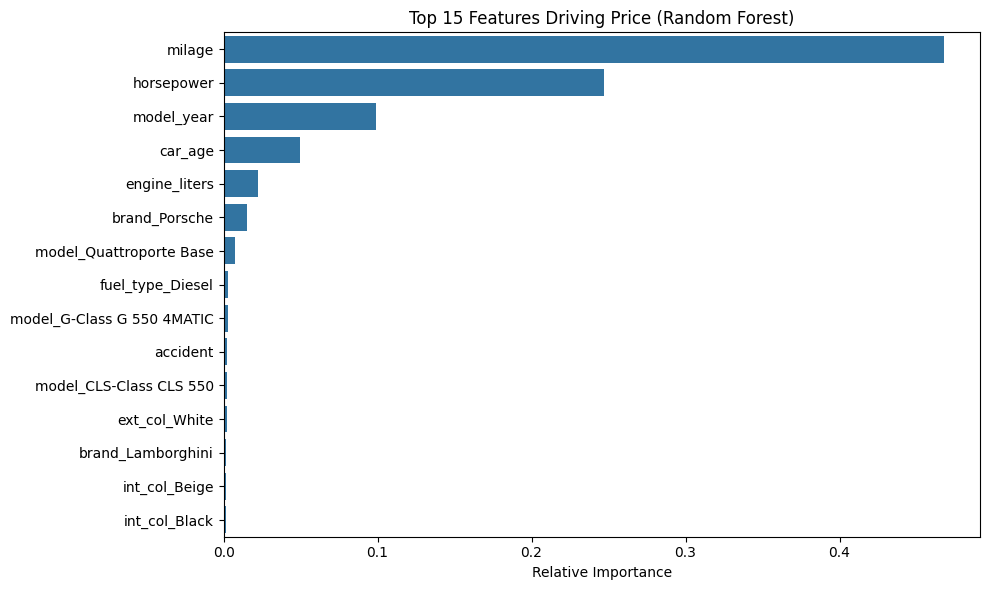

In [36]:
#3: Most Common Feature 
ohe = preprocessor.named_transformers_['cat']
cat_names = list(ohe.get_feature_names_out(categorical_cols))
num_names = numeric_cols.tolist()
all_names = num_names + cat_names

imp = rf_model.named_steps['model'].feature_importances_

import pandas as pd
top = (pd.DataFrame({"Feature": all_names, "Importance": imp})
         .sort_values("Importance", ascending=False)
         .head(15))

plt.figure(figsize=(10,6))
sns.barplot(data=top, x="Importance", y="Feature")
plt.title("Top 15 Features Driving Price (Random Forest)")
plt.xlabel("Relative Importance")
plt.ylabel("")
plt.tight_layout()
plt.show()


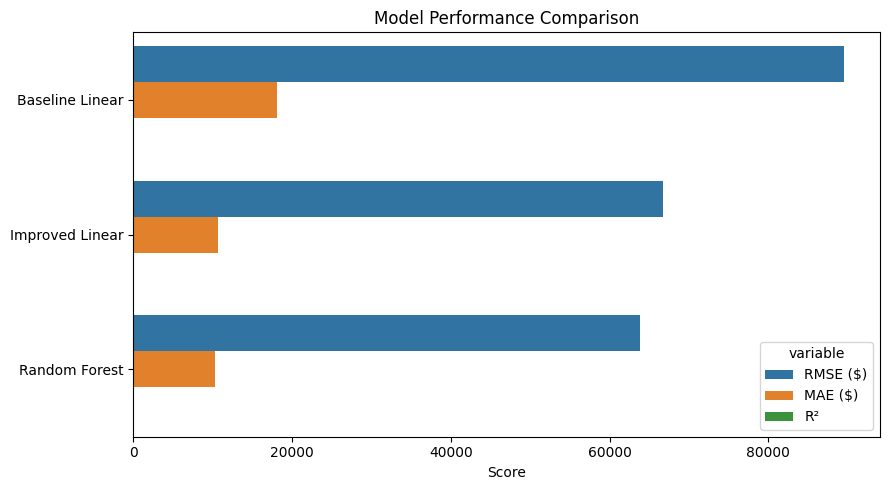

In [39]:
#4: Model COmparison

comp = pd.DataFrame({
    "Experiment": [
        "Baseline Linear",
        "Improved Linear",
        "Random Forest"
    ],
    "RMSE ($)": [rmse_bl, rmse, rmse_rf],
    "MAE ($)":  [mae_bl,  mae,  mae_rf],
    "R²":       [r2_bl,   r2,   r2_rf]
})

fig, ax = plt.subplots(figsize=(9,5))
sns.barplot(data=comp.melt(id_vars="Experiment",
                           value_vars=["RMSE ($)", "MAE ($)", "R²"]),
            x="value", y="Experiment", hue="variable", ax=ax)
ax.set_title("Model Performance Comparison")
ax.set_xlabel("Score")
ax.set_ylabel("")
plt.tight_layout()
plt.show()


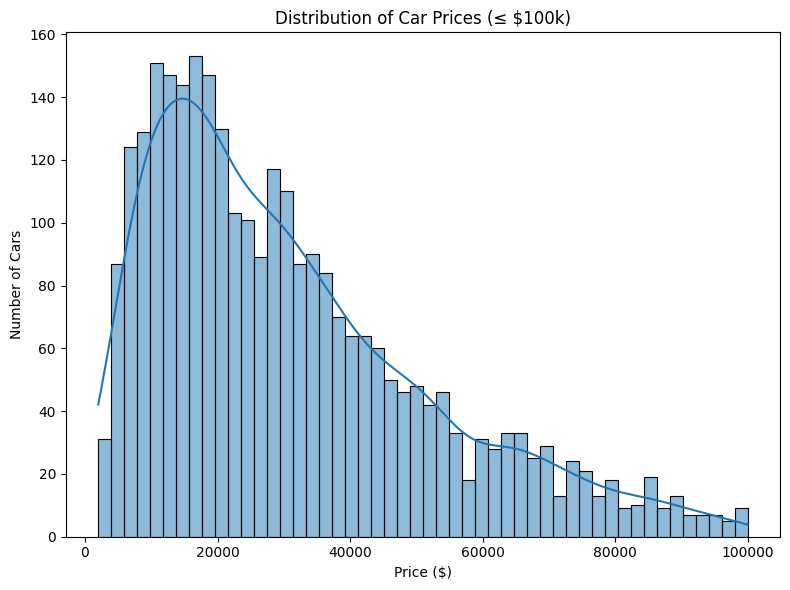

In [40]:
#5: Distribution of Car Prices 

plt.figure(figsize=(8,6))
sns.histplot(df.loc[df['price']<=100000, 'price'], bins=50, kde=True)
plt.title("Distribution of Car Prices (≤ $100k)")
plt.xlabel("Price ($)")
plt.ylabel("Number of Cars")
plt.tight_layout()
plt.show()
